In [1]:
import healpy as hp
import numpy as np

from astropy import units as u
from astropy import constants as c
from astropy.cosmology import WMAP9, Planck18

import matplotlib.pyplot as plt

import camb
from camb import model, initialpower

# The Cosmic Microwave Background (CMB) - Overview

Information on CMB
http://background.uchicago.edu/~whu/intermediate/intermediate.html

In [2]:
# Constants:
lmax = 2500  # Maximum multipole to consider for observation and theoretical models.

# Plot Observed angular power spectrum (data from Planck satellite)

To plot the observed angular power spectrum follow these steps:
1. Obtain the CMB Data (details below).
2. Remove Monopole and Dipole data.
3. Compute the power spectrum from the data. $C_\ell$
4. Convert to proper units.
5. Normalize $C_\ell$

For (1), data is downloaded from the CMB data from the Planck Legacy Archive (PLA): https://pla.esac.esa.int/.
* Create account and sign in.
* Select "CMB Maps"
* Search for "COM_CMB_IQU-smica_2048_R3.00_full.fits" (big file... 1.9GB)

For (2 & 3), Use healpy to read, preprocess, and generate the power spectrum to get $C_\ell$

For (4), healpy appears to output in $K^2$ units, covert to $uK^2$ units (micro-Kelvin)

For (5), when plotting the CMB spectrum it is common to plot $\ell(\ell+1)C_\ell/2\pi$.  This choice of y-axis makes it easier to view and interpret the data.  (Division of $2\pi$ is meant to normalize with respect to solid angle).

Note data is also available from:
https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits

In [3]:
# 1. Load the CMB map (for example, the Planck 2018 SMICA map)
cmb_map_file = "data/COM_CMB_IQU-smica_2048_R3.00_full.fits"
cmb_map = hp.read_map(cmb_map_file, field=0)  # field=0 for the temperature map

# 2. Remove the monopole and dipole components
cmb_map = hp.remove_dipole(cmb_map)

# 3. Compute the angular power spectrum
cl_observed = hp.anafast(cmb_map, lmax=lmax)

# 4. The output above is in Kelvin**2.  Convert this to microKelvin**2
cl_observed = (cl_observed * u.K**2).to(u.uK**2)

# 5. Normalize
# Create an array of multipole moments (l)
ell_observed = np.arange(len(cl_observed))

# Normalize to l(l+1), and solid angle (divide by 2pi)
cl_observed = ell_observed * (ell_observed + 1) * cl_observed / (2*np.pi)

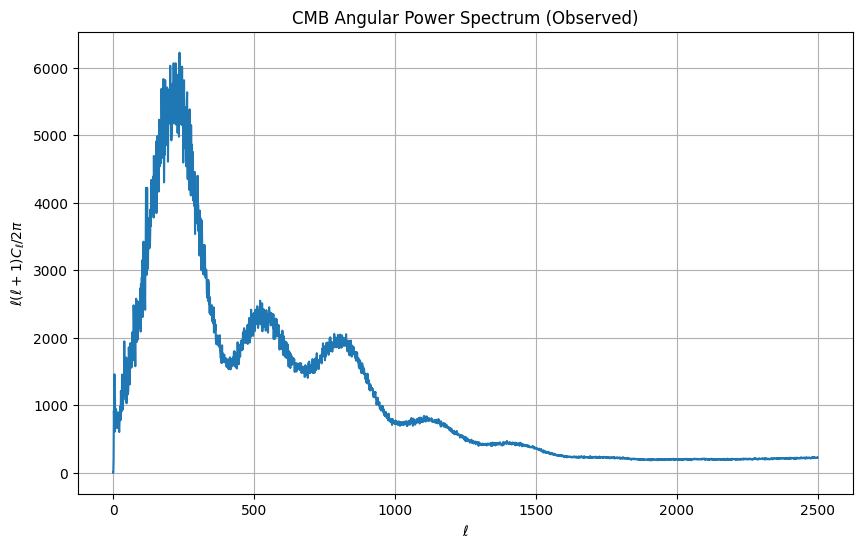

In [4]:
# Plot the angular power spectrum
plt.figure(figsize=(10, 6))
plt.plot(ell_observed, cl_observed, label='Planck Observed')
plt.xlabel("$\ell$")
plt.ylabel("$\ell (\ell + 1) C_\ell / 2\pi$")
plt.title("CMB Angular Power Spectrum (Observed)")
plt.grid()
plt.show()

# Compare Observed Against Theoretical Models

We'll use astropy cosmology for a way of shorthanding different theoretical models, and CAMB (Code for Anisotropies in the Microwave Background) to generate the $C_\ell$ for that model.  CAMB is a widely used tool to calculate the theoretical power spectra for various cosmological models, including the CMB temperature and polarization power spectra, as well as the matter power spectrum.

Documentation for initializing a CAMB model is as follows:
* **H0**: Hubble Constant at the present time, in units of km s^(-1) Mpc^(-1). It represents the current expansion rate of the universe.


* **ombh2**: The physical baryon density parameter. **_It is the product of the baryon density parameter (Ω_b) and the square of the Hubble constant (H0) divided by 100 in units of km s^(-1) Mpc^(-1).-** It describes the relative contribution of baryonic matter (protons, neutrons, etc.) to the total energy density of the universe.


* **omch2**: The physical cold dark matter density parameter. **_It is the product of the cold dark matter density parameter (Ω_c) and the square of the Hubble constant (H0) divided by 100 in units of km s^(-1) Mpc^(-1)._** It describes the relative contribution of cold dark matter to the total energy density of the universe.


* **omk**: The curvature density parameter (Ω_k). It quantifies the spatial curvature of the universe. For a flat universe, omk is equal to 0.


* **TCMB**: The temperature of the cosmic microwave background (CMB) today, in Kelvin.


* **As**: The amplitude of primordial scalar fluctuations, a key parameter for the primordial power spectrum that represents the strength of the initial density perturbations.


* **ns**: The spectral index of primordial scalar fluctuations. It quantifies the tilt of the primordial power spectrum with respect to the scale.


* **NonLinear**: A setting that indicates the type of non-linear corrections to apply to the matter power spectrum. Options include NonLinear_none (no non-linear corrections), NonLinear_pk (non-linear corrections for the power spectrum only), and NonLinear_both (non-linear corrections for both the power spectrum and the CMB lensing potential).

Other common values that we'll accept the defaults are

* **mnu**: The sum of neutrino masses, in eV. This parameter helps describe the contribution of neutrinos to the total energy density of the universe.

* **Reion.optical_depth**: The optical depth to reionization (τ). It represents the amount of Thomson scattering experienced by CMB photons due to free electrons produced during the epoch of reionization.


### Results:
First two peaks look ok.  Third and following peaks appear a little high for some reason.

In [5]:
# Function that takes an Astropy Cosmology object, and returns the power spectrum Cl.
# Note, the output of get_cmb_power_spectra is already normalized for l(l+1) and solid angle (divide by 2PI)
def power_spectrum_from_cosmology(cosmo_astropy, As = 2.105e-9, ns=0.9649):
    camb_params = camb.CAMBparams()

    # Set cosmological parameters
    camb_params.set_cosmology(
        H0=cosmo_astropy.H0.value,
        ombh2=(cosmo_astropy.Ob0 * (cosmo_astropy.H0.value / 100)**2),
        omch2=(cosmo_astropy.Om0 - cosmo_astropy.Ob0) * (cosmo_astropy.H0.value / 100)**2,
        omk=cosmo_astropy.Ok0,
        TCMB=cosmo_astropy.Tcmb0.value,
    )
    
    # Set neutrino parameters
    camb_params.set_dark_energy(w=cosmo_astropy.w(0))
    camb_params.set_initial_power(camb.InitialPowerLaw(As=As, ns=ns))
    camb_params.InitPower.set_params(As=As, ns=ns)
    camb_params.set_for_lmax(2500, lens_potential_accuracy=1)
    camb_params.NonLinear = camb.model.NonLinear_both

    results = camb.get_results(camb_params)
    
    powers = results.get_cmb_power_spectra(camb_params, CMB_unit='muK')
    
    return powers['total'][:,0]

In [6]:
# Try out Planck 2018 (latest available)
cl_Planck18 = power_spectrum_from_cosmology(Planck18)
ell_Planck18 = np.arange(len(cl_Planck18))

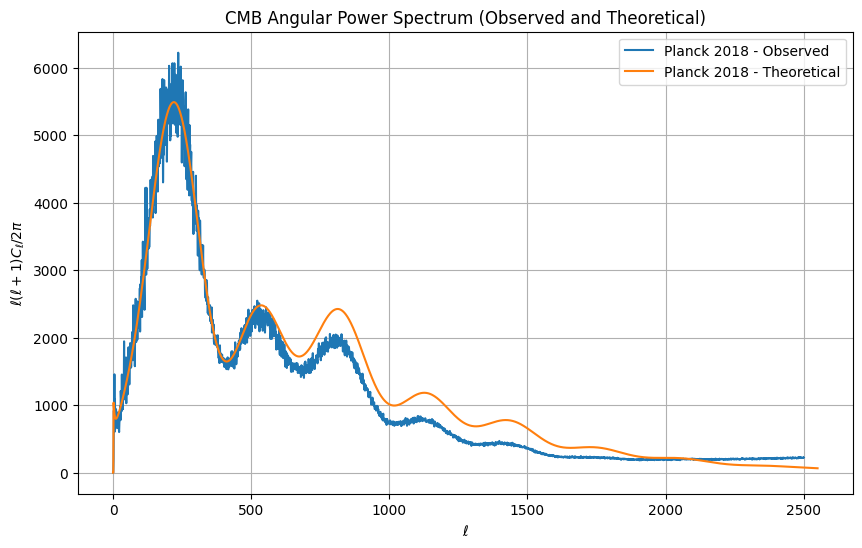

In [7]:
# Plot the angular power spectrum
plt.figure(figsize=(10, 6))
plt.plot(ell_observed, cl_observed, label='Planck 2018 - Observed')
plt.plot(ell_Planck18, cl_Planck18, label='Planck 2018 - Theoretical')
plt.xlabel("$\ell$")
plt.ylabel("$\ell (\ell + 1) C_\ell / 2\pi$")
plt.title("CMB Angular Power Spectrum (Observed and Theoretical)")
plt.legend()
plt.grid()
plt.show()

# Exploring the Theoretical Models

## Curvature impact on power spectrum.

As described in Wayne Hu's tutorial, the position of that first peak in the power spectrum of the anisotropies, and indeed all of the peaks, depend sensitively on the spatial curvature of the universe. 

In a curved universe, the positions of the peaks are shifted from their locations in a flat universe.  Specifically in a closed universe (Ω > 1), the first acoustic peak appears at a smaller multipole moment (ℓ) compared to a flat universe, corresponding to a **larger** angular scale on the sky.  In an open universe (Ω < 1), the first acoustic peak appears at a larger multipole moment(ℓ) compared to a flat universe, corresponding to a **smaller** angular scale on the sky.

In [8]:
# Create a closed cosmology by increasing the amount of dark energy while holding other
# attributes of Planck18 the same.  This results in an Omega > 1.  
# The peaks will slide to the left relative (lower multipole) to a flat cosmology.
closed_universe = Planck18.clone(to_nonflat=True, Ode0=Planck18.Ode0*1.2)
curved_universe_omega = closed_universe.Om0 + closed_universe.Ogamma0 + closed_universe.Onu0 + closed_universe.Ode0
print("Omega: {}".format(curved_universe_omega))

Omega: 1.1377692611089087


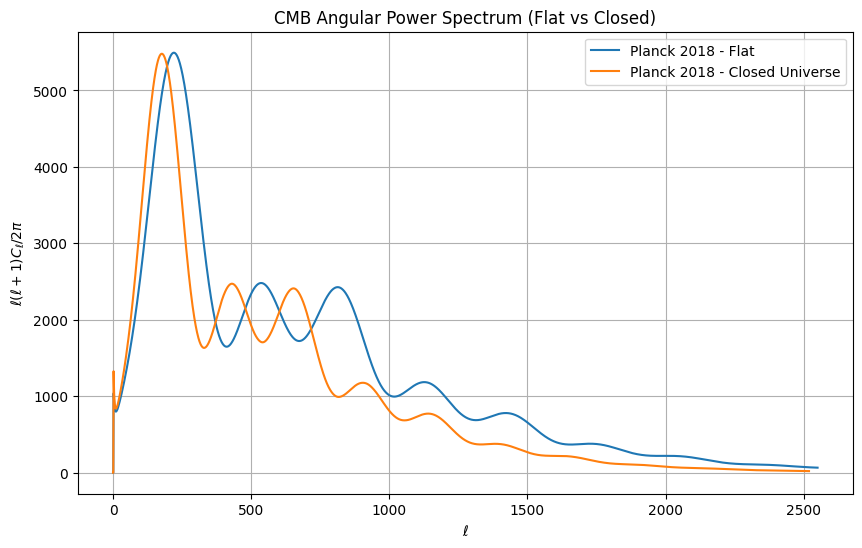

In [9]:
cl_closed_universe = power_spectrum_from_cosmology(closed_universe)
ell_closed_universe = np.arange(len(cl_closed_universe))

# Plot the angular power spectrum
plt.figure(figsize=(10, 6))
#plt.plot(ell_observed, cl_observed, label='Planck 2018 - Observed')
plt.plot(ell_Planck18, cl_Planck18, label='Planck 2018 - Flat')
plt.plot(ell_closed_universe, cl_closed_universe, label='Planck 2018 - Closed Universe')
plt.xlabel("$\ell$")
plt.ylabel("$\ell (\ell + 1) C_\ell / 2\pi$")
plt.title("CMB Angular Power Spectrum (Flat vs Closed)")
plt.legend()
plt.grid()
plt.show()

In [10]:
# Create a open cosmology by decreasing the amount of dark energy while holding other
# attributes of Planck18 the same.  This results in an Omega < 1.  
# The peaks will slide to the right relative (higher multipole) to a flat cosmology.
open_universe = Planck18.clone(to_nonflat=True, Ode0=Planck18.Ode0*0.8)
open_universe_omega = open_universe.Om0 + open_universe.Ogamma0 + open_universe.Onu0 + open_universe.Ode0
print("Omega: {}".format(open_universe_omega))

Omega: 0.8622307388910913


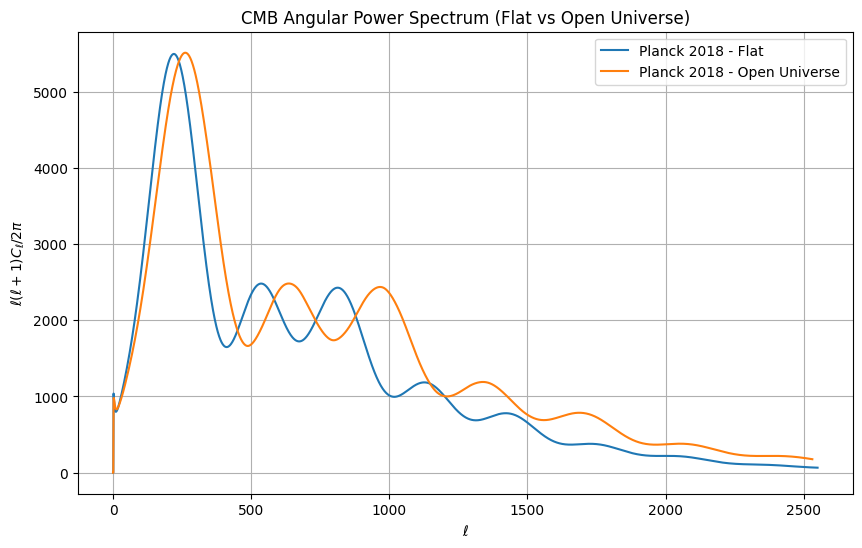

In [11]:
cl_open_universe = power_spectrum_from_cosmology(open_universe)
ell_open_universe = np.arange(len(cl_open_universe))

# Plot the angular power spectrum
plt.figure(figsize=(10, 6))
#plt.plot(ell_observed, cl_observed, label='Planck 2018 - Observed')
plt.plot(ell_Planck18, cl_Planck18, label='Planck 2018 - Flat')
plt.plot(ell_open_universe, cl_open_universe, label='Planck 2018 - Open Universe')
plt.xlabel("$\ell$")
plt.ylabel("$\ell (\ell + 1) C_\ell / 2\pi$")
plt.title("CMB Angular Power Spectrum (Flat vs Open Universe)")
plt.legend()
plt.grid()
plt.show()

## Impact of Baryonic Density

In [31]:
baryonic_density = Planck18.clone(Ob0=Planck18.Ob0*0.5)
baryonic_density_omega = baryonic_density.Om0 + baryonic_density.Ogamma0 + baryonic_density.Onu0 + baryonic_density.Ode0
print("Omega Mass: {} Omega Baryon: {}".format(baryonic_density.Om0, baryonic_density.Ob0))
print("Omega Mass: {} Omega Baryon: {}".format(Planck18.Om0, Planck18.Ob0))


Omega Mass: 0.30966 Omega Baryon: 0.024485
Omega Mass: 0.30966 Omega Baryon: 0.04897


In [32]:
cl_baryonic_density = power_spectrum_from_cosmology(baryonic_density)
ell_baryonic_density = np.arange(len(cl_baryonic_density))

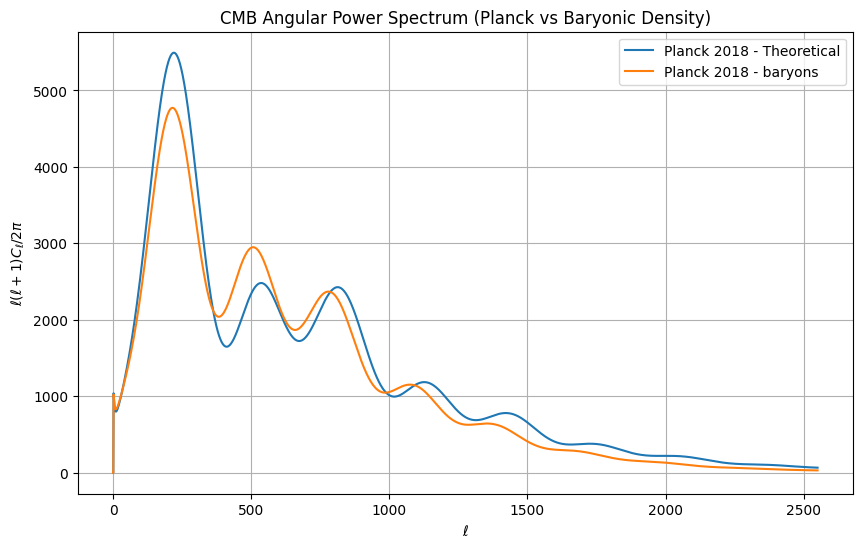

In [34]:
# Plot the angular power spectrum
plt.figure(figsize=(10, 6))
#plt.plot(ell_observed, cl_observed, label='Planck 2018 - Observed')
plt.plot(ell_Planck18, cl_Planck18, label='Planck 2018 - Theoretical')
plt.plot(ell_baryonic_density, cl_baryonic_density, label='Planck 2018 - baryons')
plt.xlabel("$\ell$")
plt.ylabel("$\ell (\ell + 1) C_\ell / 2\pi$")
plt.title("CMB Angular Power Spectrum (Planck vs Baryonic Density)")
plt.legend()
plt.grid()
plt.show()